# *C. elegans* connectomes

In [1]:
import datetime
import time

import networkx as nx
import numpy as np
import pandas as pd
from graspologic.plot import adjplot
from pkg.data import DATA_PATH
from pkg.utils import create_node_data, ensure_connected, select_lateral_nodes

FILENAME = "process_c_elegans"

DISPLAY_FIGS = True

OUT_PATH = DATA_PATH / "processed_split"

t0 = time.time()

## Load the raw adjacency matrices

In [2]:


def load_adjacency(path):
    adj_df = pd.read_csv(path, index_col=0).fillna(0)
    node_ids = np.union1d(adj_df.index, adj_df.columns)
    adj_df = adj_df.reindex(index=node_ids, columns=node_ids).fillna(0)
    adj_df = pd.DataFrame(
        data=adj_df.values.astype(int), index=adj_df.index, columns=adj_df.columns
    )
    return adj_df

## Filter data
Make sure neurons are lateralized and fully connected

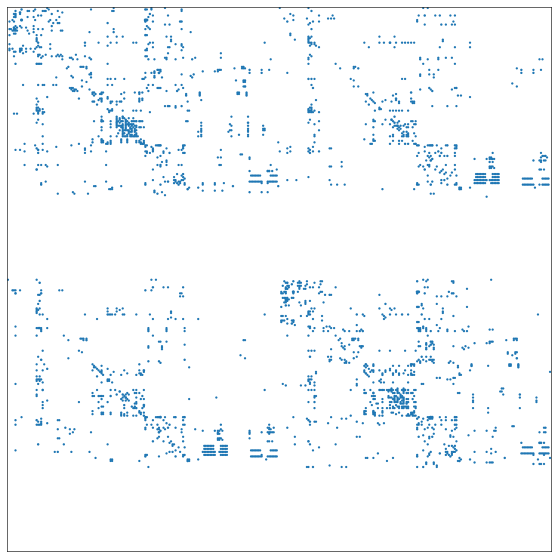

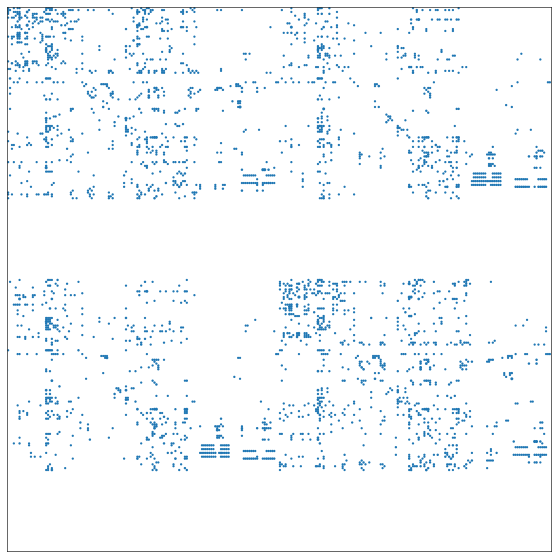

In [3]:
for sex in ["male", "herm"]:
    file_name = f"{sex}_chem_adj.csv"

    raw_path = DATA_PATH / "c_elegans"
    raw_path = raw_path / file_name

    adj_df = load_adjacency(raw_path)
    node_ids = adj_df.index
    nodes = create_node_data(node_ids, exceptions=["vBWM", "dgl", "dBWM"])
    # get rid of any nodes which don't have a side designation
    adj_df, nodes, removed_nonlateral = select_lateral_nodes(adj_df, nodes)
    # then ensure the network is fully connected
    adj_df, nodes, removed_lcc = ensure_connected(adj_df, nodes)
    # then remove any nodes whose partner got removed by that process
    adj_df, nodes, removed_partner_lcc = select_lateral_nodes(adj_df, nodes)
    # REPEAT in case this removal of partners causes disconnection
    adj_df, nodes, removed_lcc2 = ensure_connected(adj_df, nodes)
    adj_df, nodes, removed_partner_lcc2 = select_lateral_nodes(adj_df, nodes)

    adjplot(adj_df.values, plot_type="scattermap")

    g = nx.from_pandas_adjacency(adj_df, create_using=nx.DiGraph)
    nx.write_edgelist(
        g, OUT_PATH / f"{sex}_chem_edgelist.csv", delimiter=",", data=["weight"]
    )

    nodes.to_csv(OUT_PATH / f"{sex}_chem_nodes.csv")

## End

In [4]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:00.673410
Completed at 2022-05-13 13:30:25.004392
